In [1]:
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn import metrics
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
# from google.colab import drive
# drive.mount('/content/drive')
RANDOM_STATE=1234

In [2]:
def plot_model(model, data):
    core_samples_mask = np.zeros_like(model.labels_, dtype=bool)
    core_samples_mask[model.core_sample_indices_] = True
    print(model.labels_)
    print(model)

    labels = model.labels_
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)

    print("Estimated number of clusters: %d" % n_clusters_)
    print("Estimated number of noise points: %d" % n_noise_)
    #print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X, labels))

    unique_labels = set(labels)
    print("unique_labels = {unique_labels}".format(
        unique_labels=unique_labels))
    colors = [plt.cm.Spectral(each)
              for each in np.linspace(0, 1, len(unique_labels))]
    for k, col in zip(unique_labels, colors):
        if k == -1 or k == 0:
            # Black used for noise.
            #col = [0, 0, 0, 1]
            continue

        class_member_mask = labels == k

        xy = data[class_member_mask & core_samples_mask].to_numpy()
        # print(xy)
        plt.plot(
            xy[:, 0],
            xy[:, 1],
            "o",
            markerfacecolor=tuple(col),
            markeredgecolor="k",
            markersize=14,
        )

        xy = data[class_member_mask & ~core_samples_mask].to_numpy()
        plt.plot(
            xy[:, 0],
            xy[:, 1],
            "o",
            markerfacecolor=tuple(col),
            markeredgecolor="k",
            markersize=6,
        )

    plt.title("Estimated number of clusters: %d" % n_clusters_)
    plt.show()

In [3]:
def hyperparameter_tuning_DBS_sihouette(X, eps_space, min_samples_space):
    n_iterations = 0

#     eps_space = [50, 100, 150, 200, 250, 300,
#                  350, 400, 450, 500, 550, 600, 700, 800]
#     min_samples_space = [3, 5, 10, 15, 20, 25, 30, 35, 40, 50]

    min_clust = 5
    max_clust = 100
    dbscan_clusters = []
    clst_count = []

    score = 0
    for eps_val in eps_space:
        for samples_val in min_samples_space:

            dbscan_grid = DBSCAN(eps=eps_val,
                                 min_samples=samples_val,
                                 n_jobs=20)

            # fit_transform
            clusters = dbscan_grid.fit_predict(X=X)

            # Counting the amount of data in each cluster
            cluster_count = Counter(clusters)

            # Saving the number of clusters
            n_clusters = sum(abs(np.unique(clusters))) - 1

            # Increasing the iteration tally with each run of the loop
            n_iterations += 1

            # Appending the lst each time n_clusters criteria is reached
            if n_clusters >= min_clust and n_clusters <= max_clust:

                dbscan_clusters.append([eps_val,
                                        samples_val,
                                        n_clusters])

                clst_count.append(cluster_count)
                new_clst = DBSCAN(eps=eps_val,
                                  min_samples=samples_val,
                                  n_jobs=20).fit(X)
                labels = new_clst.labels_
                sihouette = metrics.silhouette_score(X, labels)
                print("Silhouette Coefficient: %0.3f" % sihouette)
                plot_model(new_clst, X)
                if sihouette > score:
                    score = sihouette
                    best_eps = eps_val
                    best_min_samples = samples_val



    # Printing grid search summary information
    print(f"""Search Complete. \nYour list is now of length {len(clst_count)}. """)
    print('The cluster with Best Silhouette Coefficient: {0:.3f} \nWith eps={1} and min_sample={2}'.format(
        score, best_eps, best_min_samples))
    print(f"""Hyperparameter combinations checked: {n_iterations}. \n""")


    print("dbscan_clusters = {dbscan_clusters}".format(
        dbscan_clusters=dbscan_clusters))
    
    return best_eps, best_min_samples

In [4]:
# df = pd.read_csv('/content/drive/MyDrive/760/Final Data/House price/SA1.csv')
df = pd.read_csv('data/SA1.csv')
df = df.drop(labels=['Unnamed: 0','median_CV'],axis=1)
df.head()

,SA12018_code,averge_room,Male,Female,Average Age,European,Māori,Pacific Peoples,Asian,Middle Eastern / Latin American / African,...,Paid employee,Employer,Self employed and without employees,Unpaid family worker,median_FA,median_AR,median_bed,median_Bath,median_Price,median_school
0,7001130,2.684211,0.580000,0.420000,41.423077,0.703125,0.265625,0.000000,0.000000,0.0,...,0.339286,0.035714,382,0.017857,-1.116825,1.306734,-2.155759,-0.752181,12.577041,0.0
1,7001131,2.161290,0.547170,0.452830,50.076923,0.746032,0.142857,0.047619,0.015873,0.0,...,0.297872,0.042553,364,0.042553,-1.324414,0.317926,-2.155759,-0.752181,12.396693,0.0
2,7001132,2.266667,0.568182,0.431818,48.190476,0.788462,0.173077,0.019231,0.019231,0.0,...,0.277778,0.037037,535,0.018519,-1.324414,0.250772,-2.155759,-0.752181,12.013701,0.0
3,7001133,2.894737,0.534884,0.465116,48.162791,0.836735,0.102041,0.000000,0.020408,0.0,...,0.325581,0.046512,392,0.023256,-1.988700,0.676994,-3.866658,-0.752181,12.236150,0.0
4,7001134,2.882353,0.640000,0.360000,51.130435,0.884615,0.038462,0.000000,0.000000,0.0,...,0.272727,0.000000,527,0.000000,-1.179101,0.267217,-2.155759,-0.752181,12.706848,0.0


In [5]:
print(df.head(10))

   SA12018_code  averge_room      Male    Female  Average Age  European  \
0       7001130     2.684211  0.580000  0.420000    41.423077  0.703125   
1       7001131     2.161290  0.547170  0.452830    50.076923  0.746032   
2       7001132     2.266667  0.568182  0.431818    48.190476  0.788462   
3       7001133     2.894737  0.534884  0.465116    48.162791  0.836735   
4       7001134     2.882353  0.640000  0.360000    51.130435  0.884615   
5       7001135     2.310345  0.500000  0.500000    46.402985  0.717647   
6       7001136     2.066667  0.481481  0.518519    49.222222  0.774194   
7       7001137     3.222222  0.500000  0.500000    39.363636  0.742424   
8       7001138     3.562500  0.500000  0.500000    33.724138  0.680000   
9       7001139     3.238095  0.484375  0.515625    39.500000  0.828947   

      Māori  Pacific Peoples     Asian  \
0  0.265625         0.000000  0.000000   
1  0.142857         0.047619  0.015873   
2  0.173077         0.019231  0.019231   
3  0.1

In [6]:
Y = df["median_Price"]
X = df.copy(True)
X = X.drop(labels=["median_Price"],axis=1)
print(X.columns)

Index(['SA12018_code', 'averge_room', 'Male', 'Female', 'Average Age',
       'European', 'Māori', 'Pacific Peoples', 'Asian',
       'Middle Eastern / Latin American / African', 'Other Ethnicity',
       'New Zealander(19)', 'Other Ethnicity nec(19)',
       'Median personal income($)', 'Employed Full time', 'Employed Part time',
       'Unemployed', 'Paid employee', 'Employer',
       'Self employed and without employees', 'Unpaid family worker',
       'median_FA', 'median_AR', 'median_bed', 'median_Bath', 'median_school'],
      dtype='object')


Silhouette Coefficient: -0.698
[-1 -1 -1 ... -1 -1 -1]
DBSCAN(eps=50, min_samples=3, n_jobs=20)
Estimated number of clusters: 8
Estimated number of noise points: 7912
unique_labels = {0, 1, 2, 3, 4, 5, 6, 7, -1}


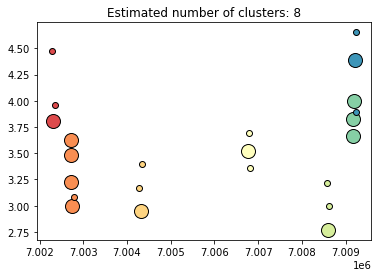

Silhouette Coefficient: -0.650
[-1 -1 -1 ... -1 -1 -1]
DBSCAN(eps=250, min_samples=15, n_jobs=20)
Estimated number of clusters: 12
Estimated number of noise points: 7730
unique_labels = {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, -1}


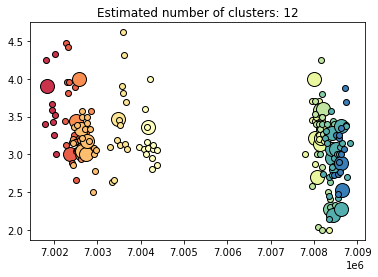

Silhouette Coefficient: -0.562
[-1 -1 -1 ... -1 -1 -1]
DBSCAN(eps=300, min_samples=20, n_jobs=20)
Estimated number of clusters: 4
Estimated number of noise points: 7828
unique_labels = {0, 1, 2, 3, -1}


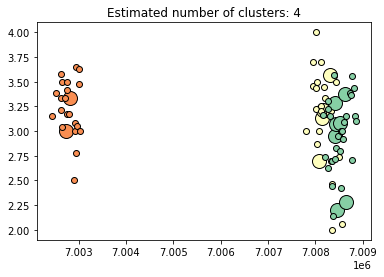

Silhouette Coefficient: -0.546
[-1 -1 -1 ... -1 -1 -1]
DBSCAN(eps=350, min_samples=25, n_jobs=20)
Estimated number of clusters: 5
Estimated number of noise points: 7723
unique_labels = {0, 1, 2, 3, 4, -1}


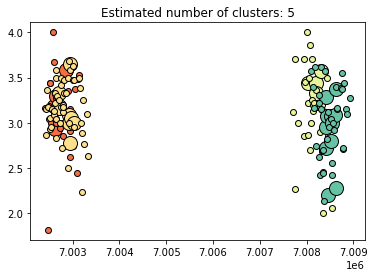

Silhouette Coefficient: -0.545
[-1 -1 -1 ... -1 -1 -1]
DBSCAN(eps=400, min_samples=30, n_jobs=20)
Estimated number of clusters: 6
Estimated number of noise points: 7700
unique_labels = {0, 1, 2, 3, 4, 5, -1}


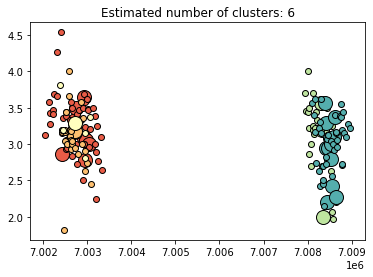

Silhouette Coefficient: -0.520
[-1 -1 -1 ... -1 -1 -1]
DBSCAN(eps=450, min_samples=35, n_jobs=20)
Estimated number of clusters: 6
Estimated number of noise points: 7436
unique_labels = {0, 1, 2, 3, 4, 5, -1}


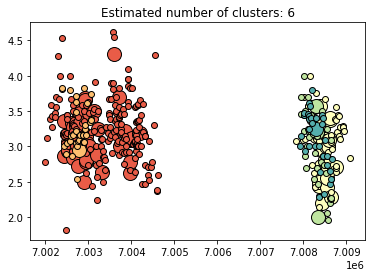

Silhouette Coefficient: -0.599
[ 0 -1  0 ...  0  0  0]
DBSCAN(eps=500, min_samples=10, n_jobs=20)
Estimated number of clusters: 14
Estimated number of noise points: 561
unique_labels = {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, -1}


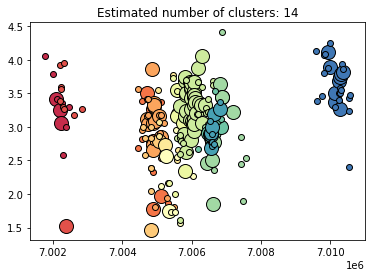

Silhouette Coefficient: -0.465
[ 2 -1  2 ...  0 13  0]
DBSCAN(eps=500, min_samples=15, n_jobs=20)
Estimated number of clusters: 14
Estimated number of noise points: 1231
unique_labels = {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, -1}


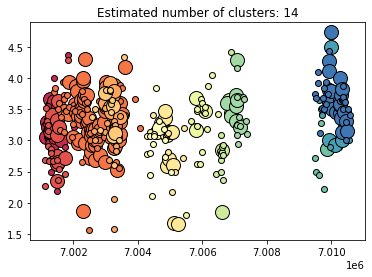

Silhouette Coefficient: -0.559
[-1 -1 -1 ... -1 -1 -1]
DBSCAN(eps=500, min_samples=40, n_jobs=20)
Estimated number of clusters: 8
Estimated number of noise points: 7321
unique_labels = {0, 1, 2, 3, 4, 5, 6, 7, -1}


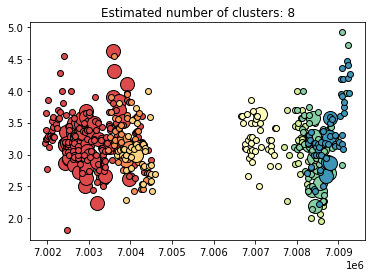

Silhouette Coefficient: -0.202
[ 0 -1  0 ...  0  0  0]
DBSCAN(eps=550, min_samples=10, n_jobs=20)
Estimated number of clusters: 9
Estimated number of noise points: 405
unique_labels = {0, 1, 2, 3, 4, 5, 6, 7, 8, -1}


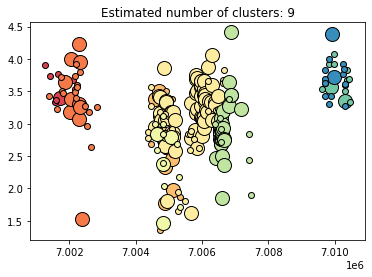

Silhouette Coefficient: -0.373
[ 2 -1  2 ...  0  0  0]
DBSCAN(eps=550, min_samples=15, n_jobs=20)
Estimated number of clusters: 10
Estimated number of noise points: 777
unique_labels = {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, -1}


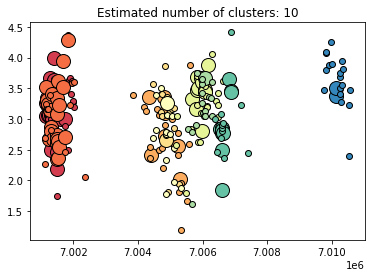

Silhouette Coefficient: -0.419
[ 2 -1  2 ...  1 -1  1]
DBSCAN(eps=550, min_samples=20, n_jobs=20)
Estimated number of clusters: 6
Estimated number of noise points: 1408
unique_labels = {0, 1, 2, 3, 4, 5, -1}


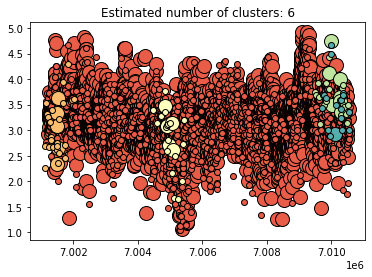

Silhouette Coefficient: -0.190
[-1 -1 -1 ... -1 -1  0]
DBSCAN(eps=550, min_samples=25, n_jobs=20)
Estimated number of clusters: 9
Estimated number of noise points: 2169
unique_labels = {0, 1, 2, 3, 4, 5, 6, 7, 8, -1}


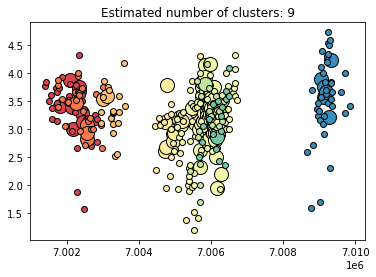

Silhouette Coefficient: -0.508
[-1 -1 -1 ... -1 -1 -1]
DBSCAN(eps=550, min_samples=50, n_jobs=20)
Estimated number of clusters: 5
Estimated number of noise points: 7479
unique_labels = {0, 1, 2, 3, 4, -1}


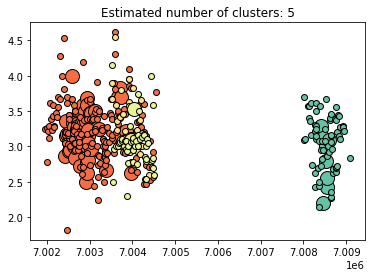

Silhouette Coefficient: -0.181
[0 1 0 ... 0 0 0]
DBSCAN(eps=600, n_jobs=20)
Estimated number of clusters: 14
Estimated number of noise points: 155
unique_labels = {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, -1}


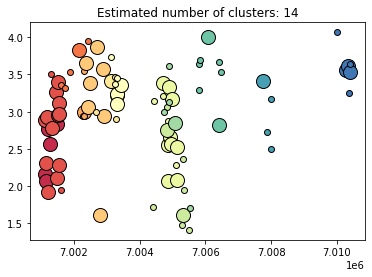

Silhouette Coefficient: 0.086
[ 0 -1  0 ...  0  0  0]
DBSCAN(eps=600, min_samples=10, n_jobs=20)
Estimated number of clusters: 4
Estimated number of noise points: 338
unique_labels = {0, 1, 2, 3, -1}


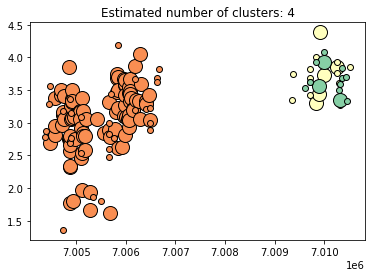

Silhouette Coefficient: -0.333
[ 0 -1  0 ...  0  0  0]
DBSCAN(eps=600, min_samples=15, n_jobs=20)
Estimated number of clusters: 9
Estimated number of noise points: 595
unique_labels = {0, 1, 2, 3, 4, 5, 6, 7, 8, -1}


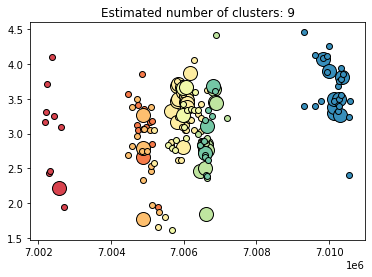

Silhouette Coefficient: -0.354
[ 2 -1  2 ...  0  0  0]
DBSCAN(eps=600, min_samples=20, n_jobs=20)
Estimated number of clusters: 6
Estimated number of noise points: 1085
unique_labels = {0, 1, 2, 3, 4, 5, -1}


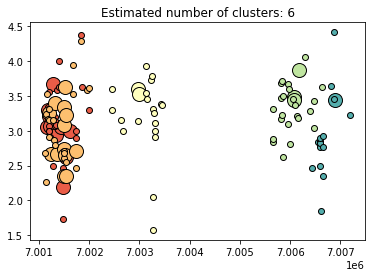

Silhouette Coefficient: -0.345
[-1 -1  1 ...  0 -1  0]
DBSCAN(eps=600, min_samples=25, n_jobs=20)
Estimated number of clusters: 4
Estimated number of noise points: 1637
unique_labels = {0, 1, 2, 3, -1}


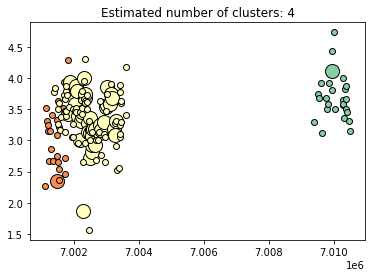

Silhouette Coefficient: -0.125
[-1 -1 -1 ... -1 -1 -1]
DBSCAN(eps=600, min_samples=30, n_jobs=20)
Estimated number of clusters: 8
Estimated number of noise points: 2289
unique_labels = {0, 1, 2, 3, 4, 5, 6, 7, -1}


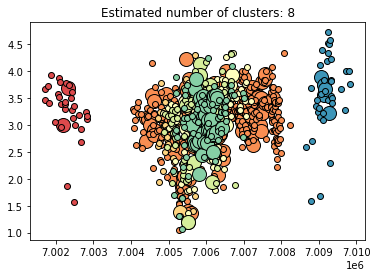

Silhouette Coefficient: -0.476
[-1 -1 -1 ... -1 -1 -1]
DBSCAN(eps=600, min_samples=35, n_jobs=20)
Estimated number of clusters: 14
Estimated number of noise points: 3278
unique_labels = {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, -1}


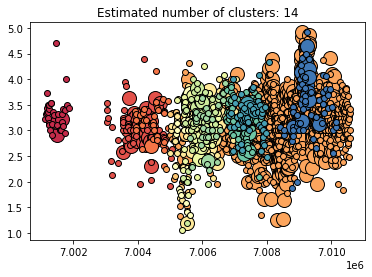

Silhouette Coefficient: -0.059
[0 1 0 ... 0 0 0]
DBSCAN(eps=700, n_jobs=20)
Estimated number of clusters: 10
Estimated number of noise points: 97
unique_labels = {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, -1}


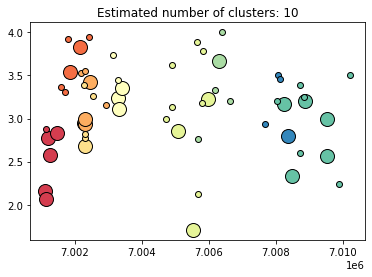

Silhouette Coefficient: -0.096
[ 0 -1  0 ...  0  0  0]
DBSCAN(eps=700, min_samples=15, n_jobs=20)
Estimated number of clusters: 6
Estimated number of noise points: 385
unique_labels = {0, 1, 2, 3, 4, 5, -1}


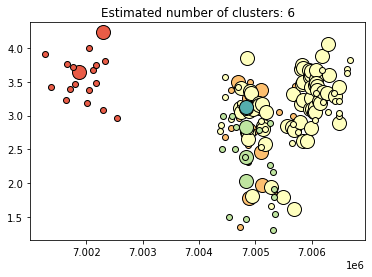

Silhouette Coefficient: -0.259
[ 0 -1  0 ...  0  0  0]
DBSCAN(eps=700, min_samples=20, n_jobs=20)
Estimated number of clusters: 5
Estimated number of noise points: 570
unique_labels = {0, 1, 2, 3, 4, -1}


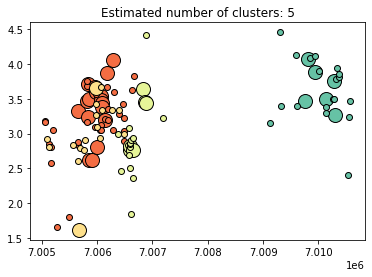

Silhouette Coefficient: -0.112
[ 1 -1  1 ...  0  0  0]
DBSCAN(eps=700, min_samples=25, n_jobs=20)
Estimated number of clusters: 4
Estimated number of noise points: 900
unique_labels = {0, 1, 2, 3, -1}


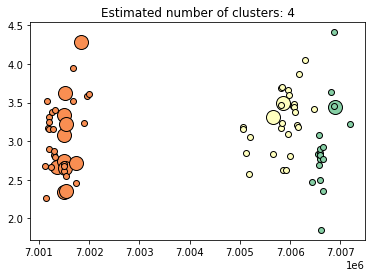

Silhouette Coefficient: -0.105
[-1 -1 -1 ... -1  3  0]
DBSCAN(eps=700, min_samples=35, n_jobs=20)
Estimated number of clusters: 4
Estimated number of noise points: 1583
unique_labels = {0, 1, 2, 3, -1}


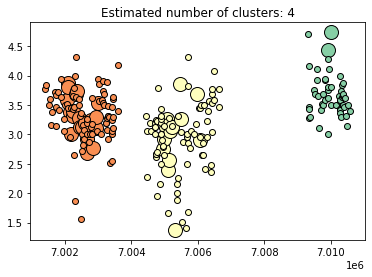

Silhouette Coefficient: -0.154
[-1 -1 -1 ... -1 -1 -1]
DBSCAN(eps=700, min_samples=40, n_jobs=20)
Estimated number of clusters: 6
Estimated number of noise points: 2111
unique_labels = {0, 1, 2, 3, 4, 5, -1}


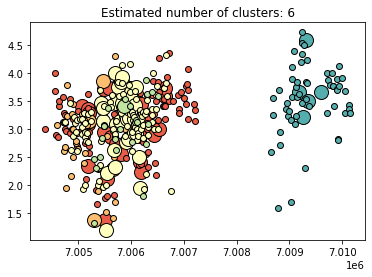

Silhouette Coefficient: -0.264
[-1 -1 -1 ... -1 -1 -1]
DBSCAN(eps=700, min_samples=50, n_jobs=20)
Estimated number of clusters: 8
Estimated number of noise points: 3770
unique_labels = {0, 1, 2, 3, 4, 5, 6, 7, -1}


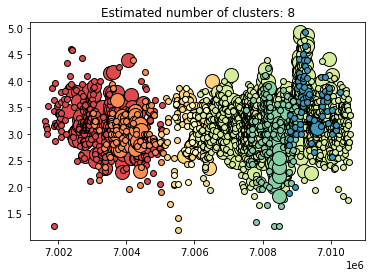

Silhouette Coefficient: -0.080
[0 1 0 ... 0 0 0]
DBSCAN(eps=800, min_samples=3, n_jobs=20)
Estimated number of clusters: 13
Estimated number of noise points: 37
unique_labels = {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, -1}


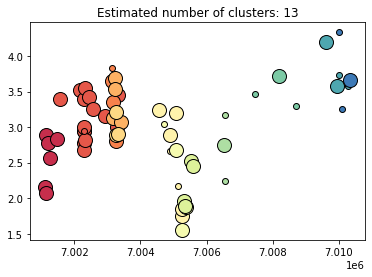

Silhouette Coefficient: -0.005
[0 1 0 ... 0 0 0]
DBSCAN(eps=800, n_jobs=20)
Estimated number of clusters: 5
Estimated number of noise points: 79
unique_labels = {0, 1, 2, 3, 4, -1}


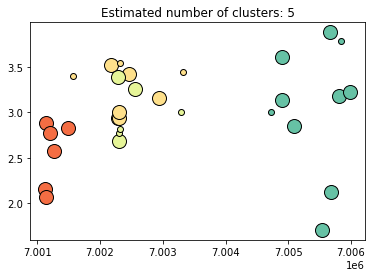

Silhouette Coefficient: 0.085
[ 0 -1  0 ...  0  0  0]
DBSCAN(eps=800, min_samples=20, n_jobs=20)
Estimated number of clusters: 4
Estimated number of noise points: 400
unique_labels = {0, 1, 2, 3, -1}


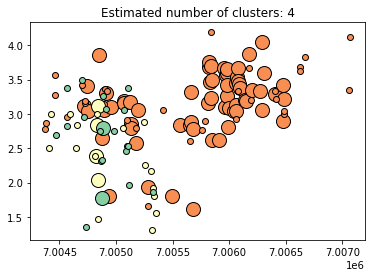

Silhouette Coefficient: 0.006
[ 0 -1  0 ...  0  0  0]
DBSCAN(eps=800, min_samples=25, n_jobs=20)
Estimated number of clusters: 4
Estimated number of noise points: 513
unique_labels = {0, 1, 2, 3, -1}


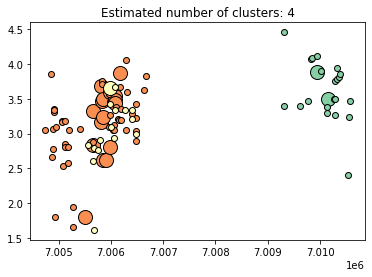

Silhouette Coefficient: -0.094
[ 1 -1  1 ...  0  0  0]
DBSCAN(eps=800, min_samples=30, n_jobs=20)
Estimated number of clusters: 4
Estimated number of noise points: 731
unique_labels = {0, 1, 2, 3, -1}


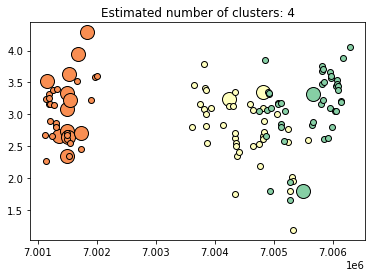

Silhouette Coefficient: -0.259
[-1 -1 -1 ...  0 -1 -1]
DBSCAN(eps=800, min_samples=50, n_jobs=20)
Estimated number of clusters: 5
Estimated number of noise points: 1827
unique_labels = {0, 1, 2, 3, 4, -1}


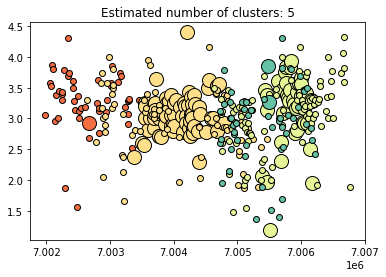

Search Complete. 
Your list is now of length 34. 
The cluster with Best Silhouette Coefficient: 0.086 
With eps=600 and min_sample=10
Hyperparameter combinations checked: 140. 

dbscan_clusters = [[50, 3, 28], [250, 15, 66], [300, 20, 6], [350, 25, 10], [400, 30, 15], [450, 35, 15], [500, 10, 91], [500, 15, 91], [500, 40, 28], [550, 10, 36], [550, 15, 45], [550, 20, 15], [550, 25, 36], [550, 50, 10], [600, 5, 91], [600, 10, 6], [600, 15, 36], [600, 20, 15], [600, 25, 6], [600, 30, 28], [600, 35, 91], [700, 5, 45], [700, 15, 15], [700, 20, 10], [700, 25, 6], [700, 35, 6], [700, 40, 15], [700, 50, 28], [800, 3, 78], [800, 5, 10], [800, 20, 6], [800, 25, 6], [800, 30, 6], [800, 50, 10]]


In [7]:
eps_space = [50, 100, 150, 200, 250, 300,
             350, 400, 450, 500, 550, 600, 700, 800]
min_samples_space = [3, 5, 10, 15, 20, 25, 30, 35, 40, 50]
best_eps,best_min_samples=hyperparameter_tuning_DBS_sihouette(X, eps_space, min_samples_space)

Silhouette Coefficient: 0.086
[ 0 -1  0 ...  0  0  0]
DBSCAN(eps=600, min_samples=10, n_jobs=-1)
Estimated number of clusters: 4
Estimated number of noise points: 338
unique_labels = {0, 1, 2, 3, -1}


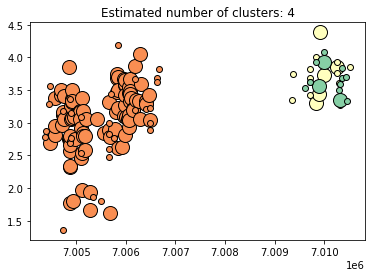

In [8]:
# Final model, pick the best sihouette from above
clustering = DBSCAN(eps=best_eps, min_samples=best_min_samples,n_jobs=-1)  # .fit(X)
clustering.fit(X)
clustering_labels = clustering.fit_predict(X)
print("Silhouette Coefficient: %0.3f"%metrics.silhouette_score(X, clustering_labels))
plot_model(clustering, X)

# crime


In [9]:
df_crime = pd.read_csv('data/Final_Property_crime_census.csv')
df_crime = df_crime.drop(labels=['Unnamed: 0','median_CV'],axis=1)
df_crime.head()

,SA12018_code,averge_room,Male,Female,Average Age,European,Māori,Pacific Peoples,Asian,Middle Eastern / Latin American / African,...,median_FA,median_AR,median_bed,median_Bath,median_Price,median_school,weighted_weapon,weighted_crime,Number_of_happens,Number of Victimisations
0,7001130,2.684211,0.580000,0.420000,41.423077,0.703125,0.265625,0.000000,0.000000,0.0,...,-1.116825,1.306734,-2.155759,-0.752181,12.577041,0.0,0.0,0.470588,8,8
1,7001131,2.161290,0.547170,0.452830,50.076923,0.746032,0.142857,0.047619,0.015873,0.0,...,-1.324414,0.317926,-2.155759,-0.752181,12.396693,0.0,0.0,0.647059,11,11
2,7001132,2.266667,0.568182,0.431818,48.190476,0.788462,0.173077,0.019231,0.019231,0.0,...,-1.324414,0.250772,-2.155759,-0.752181,12.013701,0.0,0.0,0.647059,11,12
3,7001134,2.882353,0.640000,0.360000,51.130435,0.884615,0.038462,0.000000,0.000000,0.0,...,-1.179101,0.267217,-2.155759,-0.752181,12.706848,0.0,0.0,0.647059,11,11
4,7001135,2.310345,0.500000,0.500000,46.402985,0.717647,0.211765,0.011765,0.011765,0.0,...,-1.158342,0.441270,-2.155759,-0.752181,12.396693,0.0,0.0,0.294118,5,5


In [10]:
Y = df_crime["median_Price"]
X = df_crime.copy(True)
X = X.drop(labels=["median_Price"],axis=1)
print(X.columns)

Index(['SA12018_code', 'averge_room', 'Male', 'Female', 'Average Age',
       'European', 'Māori', 'Pacific Peoples', 'Asian',
       'Middle Eastern / Latin American / African', 'Other Ethnicity',
       'New Zealander(19)', 'Other Ethnicity nec(19)',
       'Median personal income($)', 'Employed Full time', 'Employed Part time',
       'Unemployed', 'Paid employee', 'Employer',
       'Self employed and without employees', 'Unpaid family worker',
       'median_FA', 'median_AR', 'median_bed', 'median_Bath', 'median_school',
       'weighted_weapon', 'weighted_crime', 'Number_of_happens',
       'Number of Victimisations'],
      dtype='object')


Silhouette Coefficient: -0.628
[-1 -1 -1 ... -1 -1 -1]
DBSCAN(eps=50, min_samples=3, n_jobs=20)
Estimated number of clusters: 5
Estimated number of noise points: 7402
unique_labels = {0, 1, 2, 3, 4, -1}


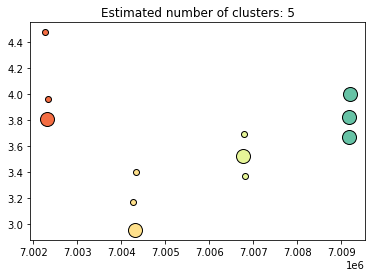

Silhouette Coefficient: -0.693
[-1 -1 -1 ... -1 -1 -1]
DBSCAN(eps=200, min_samples=10, n_jobs=20)
Estimated number of clusters: 7
Estimated number of noise points: 7337
unique_labels = {0, 1, 2, 3, 4, 5, 6, -1}


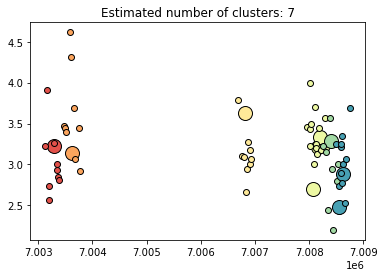

Silhouette Coefficient: -0.581
[-1 -1 -1 ... -1 -1 -1]
DBSCAN(eps=400, min_samples=25, n_jobs=20)
Estimated number of clusters: 13
Estimated number of noise points: 6826
unique_labels = {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, -1}


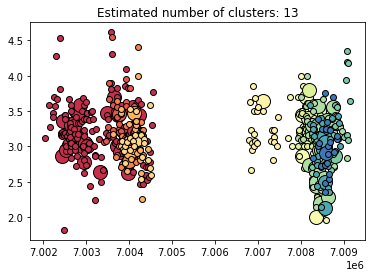

Silhouette Coefficient: -0.534
[-1 -1 -1 ... -1 -1 -1]
DBSCAN(eps=450, min_samples=35, n_jobs=20)
Estimated number of clusters: 6
Estimated number of noise points: 7136
unique_labels = {0, 1, 2, 3, 4, 5, -1}


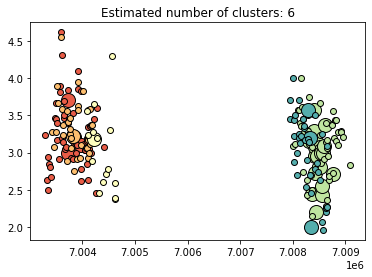

Silhouette Coefficient: -0.498
[-1 -1 -1 ... -1 -1 -1]
DBSCAN(eps=500, min_samples=35, n_jobs=20)
Estimated number of clusters: 14
Estimated number of noise points: 6381
unique_labels = {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, -1}


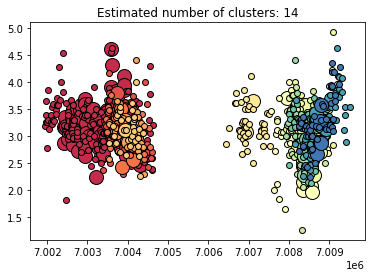

Silhouette Coefficient: -0.525
[-1 -1 -1 ... -1 -1 -1]
DBSCAN(eps=500, min_samples=40, n_jobs=20)
Estimated number of clusters: 6
Estimated number of noise points: 7053
unique_labels = {0, 1, 2, 3, 4, 5, -1}


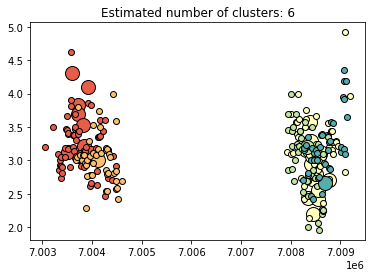

Silhouette Coefficient: -0.413
[ 0 -1  0 ... -1  0  0]
DBSCAN(eps=550, min_samples=10, n_jobs=20)
Estimated number of clusters: 9
Estimated number of noise points: 495
unique_labels = {0, 1, 2, 3, 4, 5, 6, 7, 8, -1}


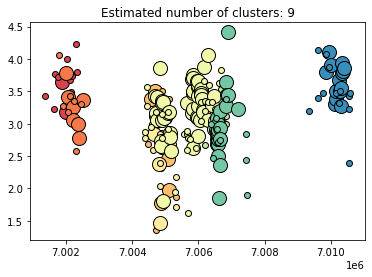

Silhouette Coefficient: -0.396
[ 2 -1  2 ... -1  0  0]
DBSCAN(eps=550, min_samples=15, n_jobs=20)
Estimated number of clusters: 13
Estimated number of noise points: 889
unique_labels = {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, -1}


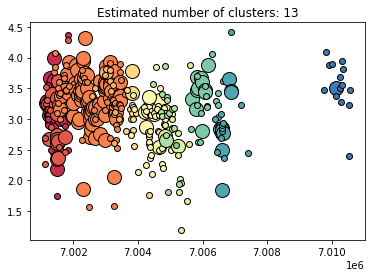

Silhouette Coefficient: -0.370
[-1 -1  1 ... -1 -1  0]
DBSCAN(eps=550, min_samples=20, n_jobs=20)
Estimated number of clusters: 9
Estimated number of noise points: 1571
unique_labels = {0, 1, 2, 3, 4, 5, 6, 7, 8, -1}


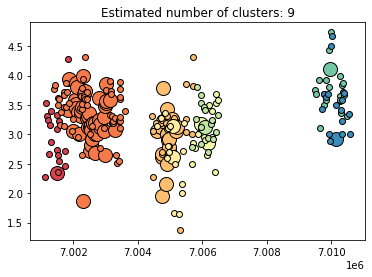

Silhouette Coefficient: -0.412
[-1 -1 -1 ... -1 -1 -1]
DBSCAN(eps=550, min_samples=30, n_jobs=20)
Estimated number of clusters: 14
Estimated number of noise points: 3774
unique_labels = {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, -1}


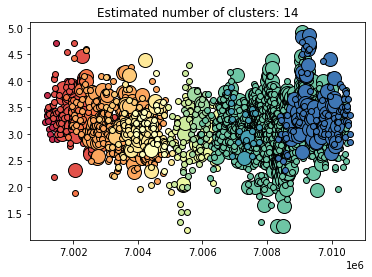

Silhouette Coefficient: -0.218
[ 0  1  0 ... -1  0  0]
DBSCAN(eps=600, n_jobs=20)
Estimated number of clusters: 11
Estimated number of noise points: 226
unique_labels = {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, -1}


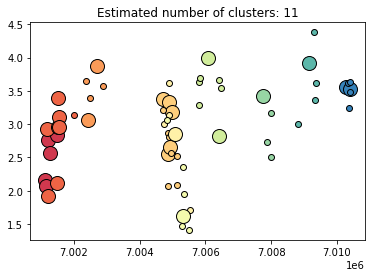

Silhouette Coefficient: 0.136
[ 0 -1  0 ... -1  0  0]
DBSCAN(eps=600, min_samples=10, n_jobs=20)
Estimated number of clusters: 4
Estimated number of noise points: 397
unique_labels = {0, 1, 2, 3, -1}


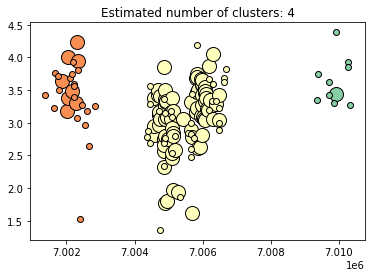

Silhouette Coefficient: -0.360
[ 1 -1  1 ... -1  0  0]
DBSCAN(eps=600, min_samples=15, n_jobs=20)
Estimated number of clusters: 9
Estimated number of noise points: 692
unique_labels = {0, 1, 2, 3, 4, 5, 6, 7, 8, -1}


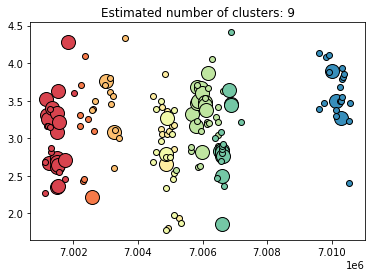

Silhouette Coefficient: -0.445
[-1 -1  2 ... -1  7  0]
DBSCAN(eps=600, min_samples=20, n_jobs=20)
Estimated number of clusters: 10
Estimated number of noise points: 1226
unique_labels = {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, -1}


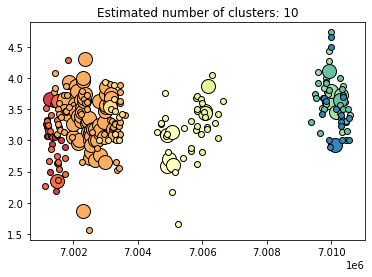

Silhouette Coefficient: -0.028
[-1 -1 -1 ... -1 -1  0]
DBSCAN(eps=600, min_samples=25, n_jobs=20)
Estimated number of clusters: 6
Estimated number of noise points: 1781
unique_labels = {0, 1, 2, 3, 4, 5, -1}


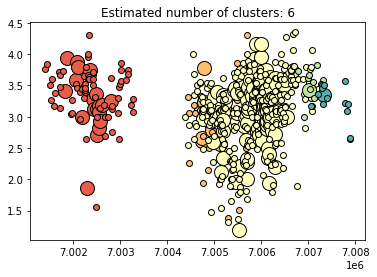

Silhouette Coefficient: -0.477
[-1 -1 -1 ... -1 -1 -1]
DBSCAN(eps=600, min_samples=50, n_jobs=20)
Estimated number of clusters: 10
Estimated number of noise points: 6512
unique_labels = {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, -1}


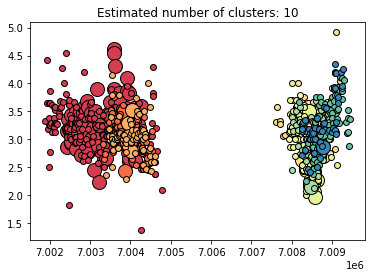

Silhouette Coefficient: -0.056
[ 0  1  0 ... -1  0  0]
DBSCAN(eps=700, min_samples=3, n_jobs=20)
Estimated number of clusters: 12
Estimated number of noise points: 103
unique_labels = {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, -1}


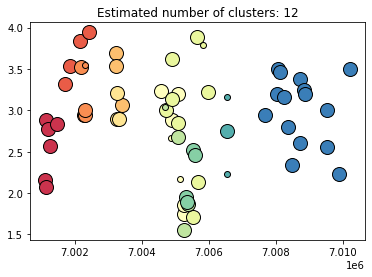

Silhouette Coefficient: -0.071
[ 0  1  0 ... -1  0  0]
DBSCAN(eps=700, n_jobs=20)
Estimated number of clusters: 10
Estimated number of noise points: 143
unique_labels = {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, -1}


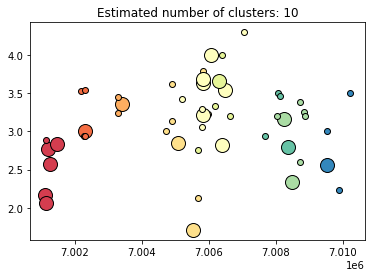

Silhouette Coefficient: -0.218
[ 0 -1  0 ... -1  0  0]
DBSCAN(eps=700, min_samples=10, n_jobs=20)
Estimated number of clusters: 5
Estimated number of noise points: 294
unique_labels = {0, 1, 2, 3, 4, -1}


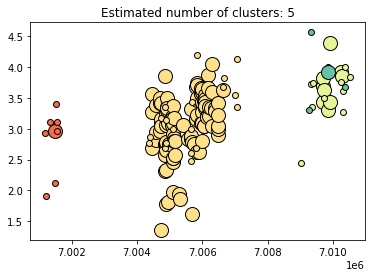

Silhouette Coefficient: -0.104
[ 0 -1  0 ... -1  0  0]
DBSCAN(eps=700, min_samples=15, n_jobs=20)
Estimated number of clusters: 6
Estimated number of noise points: 410
unique_labels = {0, 1, 2, 3, 4, 5, -1}


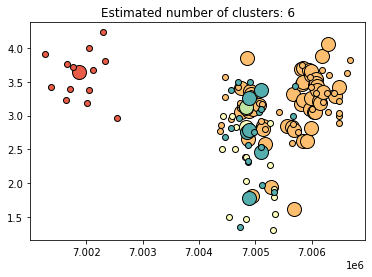

Silhouette Coefficient: -0.325
[ 0 -1  0 ... -1  1  1]
DBSCAN(eps=700, min_samples=20, n_jobs=20)
Estimated number of clusters: 6
Estimated number of noise points: 639
unique_labels = {0, 1, 2, 3, 4, 5, -1}


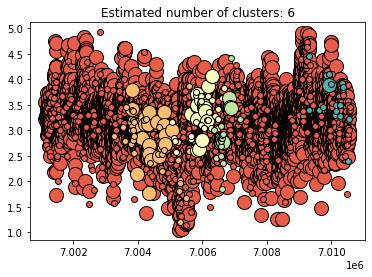

Silhouette Coefficient: -0.385
[-1 -1  1 ... -1  4  0]
DBSCAN(eps=700, min_samples=25, n_jobs=20)
Estimated number of clusters: 5
Estimated number of noise points: 1013
unique_labels = {0, 1, 2, 3, 4, -1}


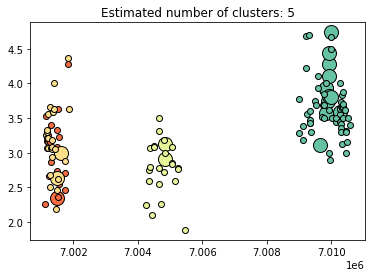

Silhouette Coefficient: -0.131
[-1 -1 -1 ... -1  7 -1]
DBSCAN(eps=700, min_samples=35, n_jobs=20)
Estimated number of clusters: 8
Estimated number of noise points: 1715
unique_labels = {0, 1, 2, 3, 4, 5, 6, 7, -1}


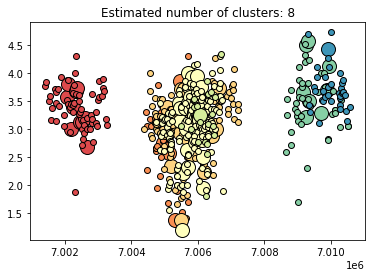

Silhouette Coefficient: -0.414
[-1 -1 -1 ... -1 -1 -1]
DBSCAN(eps=700, min_samples=40, n_jobs=20)
Estimated number of clusters: 9
Estimated number of noise points: 2593
unique_labels = {0, 1, 2, 3, 4, 5, 6, 7, 8, -1}


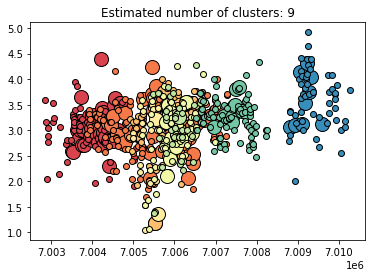

Silhouette Coefficient: -0.216
[-1 -1 -1 ... -1 -1 -1]
DBSCAN(eps=700, min_samples=50, n_jobs=20)
Estimated number of clusters: 9
Estimated number of noise points: 4091
unique_labels = {0, 1, 2, 3, 4, 5, 6, 7, 8, -1}


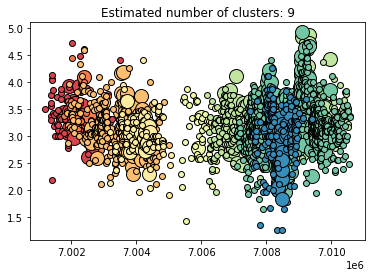

Silhouette Coefficient: -0.162
[ 0  1  0 ... -1  0  0]
DBSCAN(eps=800, min_samples=3, n_jobs=20)
Estimated number of clusters: 14
Estimated number of noise points: 68
unique_labels = {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, -1}


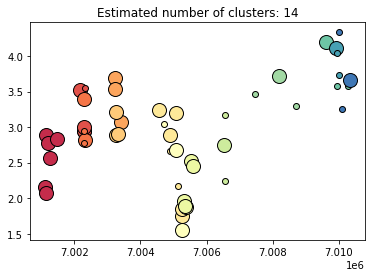

Silhouette Coefficient: -0.050
[ 0  1  0 ... -1  0  0]
DBSCAN(eps=800, n_jobs=20)
Estimated number of clusters: 5
Estimated number of noise points: 114
unique_labels = {0, 1, 2, 3, 4, -1}


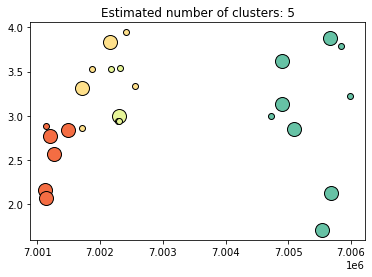

Silhouette Coefficient: -0.199
[ 0 -1  0 ... -1  0  0]
DBSCAN(eps=800, min_samples=20, n_jobs=20)
Estimated number of clusters: 5
Estimated number of noise points: 429
unique_labels = {0, 1, 2, 3, 4, -1}


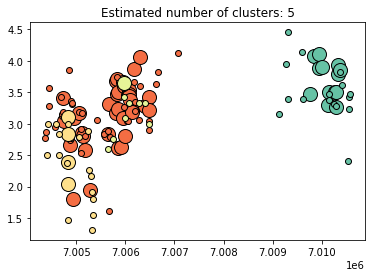

Silhouette Coefficient: -0.099
[ 1 -1  1 ... -1  0  0]
DBSCAN(eps=800, min_samples=25, n_jobs=20)
Estimated number of clusters: 4
Estimated number of noise points: 607
unique_labels = {0, 1, 2, 3, -1}


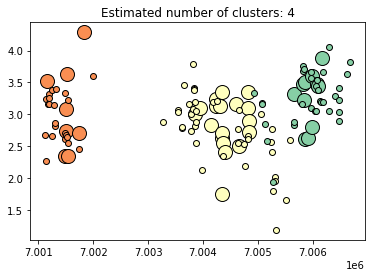

Silhouette Coefficient: -0.301
[-1 -1 -1 ... -1 -1 -1]
DBSCAN(eps=800, min_samples=50, n_jobs=20)
Estimated number of clusters: 6
Estimated number of noise points: 2196
unique_labels = {0, 1, 2, 3, 4, 5, -1}


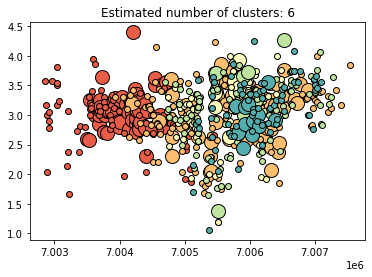

Search Complete. 
Your list is now of length 30. 
The cluster with Best Silhouette Coefficient: 0.136 
With eps=600 and min_sample=10
Hyperparameter combinations checked: 140. 

dbscan_clusters = [[50, 3, 10], [200, 10, 21], [400, 25, 78], [450, 35, 15], [500, 35, 91], [500, 40, 15], [550, 10, 36], [550, 15, 78], [550, 20, 36], [550, 30, 91], [600, 5, 55], [600, 10, 6], [600, 15, 36], [600, 20, 45], [600, 25, 15], [600, 50, 45], [700, 3, 66], [700, 5, 45], [700, 10, 10], [700, 15, 15], [700, 20, 15], [700, 25, 10], [700, 35, 28], [700, 40, 36], [700, 50, 36], [800, 3, 91], [800, 5, 10], [800, 20, 10], [800, 25, 6], [800, 50, 15]]


In [11]:
eps_space = [50, 100, 150, 200, 250, 300,
             350, 400, 450, 500, 550, 600, 700, 800]
min_samples_space = [3, 5, 10, 15, 20, 25, 30, 35, 40, 50]
best_eps,best_min_samples=hyperparameter_tuning_DBS_sihouette(X, eps_space, min_samples_space)

Silhouette Coefficient: 0.136
[ 0 -1  0 ... -1  0  0]
DBSCAN(eps=600, min_samples=10, n_jobs=20)
Estimated number of clusters: 4
Estimated number of noise points: 397
unique_labels = {0, 1, 2, 3, -1}


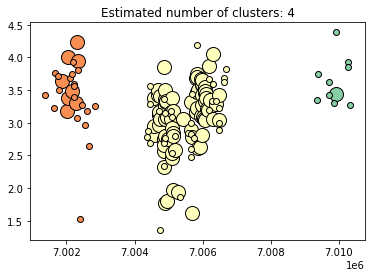

In [12]:
# Final model, pick the best sihouette from above
clustering = DBSCAN(eps=best_eps, min_samples=best_min_samples,n_jobs=20)  # .fit(X)
clustering.fit(X)
clustering_labels = clustering.fit_predict(X)
print("Silhouette Coefficient: %0.3f"%metrics.silhouette_score(X, clustering_labels))
plot_model(clustering, X)

In [13]:
# clustering = DBSCAN(eps=best_eps, min_samples=best_min_samples, n_jobs=20)
# clustering.fit(X)

# plot_model(clustering,X)

In [14]:
# # Starting a tally of total iterations
# n_iterations = 0

# eps_space = [ 50,100,150,200,250,300,350,400,450,500,550,600,700,800]
# min_samples_space = [3,5,10,15,20,25,30,35,40,50]

# min_clust = 5
# max_clust = 100
# dbscan_clusters = []
# clst_count = []

# # Looping over each combination of hyperparameters
# for eps_val in eps_space:
#     for samples_val in min_samples_space:

#         dbscan_grid = DBSCAN(eps = eps_val,
#                             min_samples = samples_val,
#                              n_jobs = 20)


#         # fit_transform
#         clusters = dbscan_grid.fit_predict(X = X)

#         # Counting the amount of data in each cluster
#         cluster_count = Counter(clusters)


#         # Saving the number of clusters
#         n_clusters = sum(abs(np.unique(clusters))) - 1


#         # Increasing the iteration tally with each run of the loop
#         n_iterations += 1


#         # Appending the lst each time n_clusters criteria is reached
#         if n_clusters >= min_clust and n_clusters <= max_clust:

#             dbscan_clusters.append([eps_val,
#                                     samples_val,
#                                     n_clusters])


#             clst_count.append(cluster_count)
#             new_clst = DBSCAN(eps = eps_val,
#                             min_samples = samples_val,
#                              n_jobs = 20).fit(X)
#             plot_model(new_clst,X)

# # Printing grid search summary information
# print(f"""Search Complete. \nYour list is now of length {len(clst_count)}. """)
# print(f"""Hyperparameter combinations checked: {n_iterations}. \n""")

# print("dbscan_clusters = {dbscan_clusters}".format(dbscan_clusters=dbscan_clusters))